In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
masks = pd.read_csv('/Users/shengmiw/Downloads/train_ship_segmentations_v2.csv')
masks.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [3]:
null_masks = masks['EncodedPixels'].isnull()
selected = masks['ImageId'][null_masks].tolist()
empty_ships = set()
for s in selected:
    empty_ships.add(s)

In [4]:
len(empty_ships)

150000

In [5]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [32]:
mask1 = masks.loc[masks['ImageId'] == '000194a2d.jpg', 'EncodedPixels']


In [33]:
mask1 = mask1.tolist()

In [34]:
all_masks1 = np.zeros((768, 768))
for m in mask1:
    all_masks1 += rle_decode(m)

In [35]:
import matplotlib.pyplot as plt

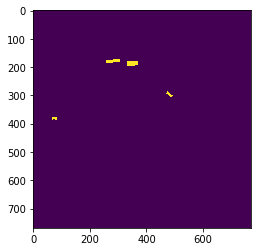

In [36]:
plt.imshow(all_masks1)
plt.show()

In [40]:
# implementation of box generation algorithm
# search

def box_genV1(grid):
    """
        input: grid - ndarray of mask shape: N * M
        outupt: boxes array of cors
    """
    grid = grid.astype(np.int)
    min_area = 10
    N,M = grid.shape
    mask = np.zeros((N,M), np.int)
    bboxes = []
    cur_max = 0
    for i in range(N):
        for j in range(M):
            if not grid[i,j]:
                continue
            elif mask[i,j]:
                continue
            else:
                if i - 1 >= 0 and grid[i - 1, j]:
                    mask[i,j] = mask[i - 1, j]
                elif j - 1 >= 0 and grid[i, j - 1]:
                    mask[i,j] = mask[i, j - 1]
                else:
                    # in this case, it's a new area
                    mask[i,j] = cur_max + 1
                    cur_max += 1
                    
    n_boxes = cur_max
    for i in range(n_boxes):
        idx, idy = np.where(mask == i+1)
        xmin, xmax, ymin, ymax = idx.min(), idx.max(), idy.min(), idy.max()
        print('the area is: ', (xmax - xmin) * (ymax - ymin))
        if (xmax - xmin) * (ymax - ymin) > min_area:
            bboxes.append((xmin, xmax, ymin, ymax))
        
    return bboxes


In [56]:
from skimage.measure import label, regionprops
def box_genV2(grid):
    lbl = label(grid) 
    props = regionprops(lbl)
    return np.asarray([prop.bbox for prop in props])

In [57]:
grid = all_masks1
res = box_genV2(grid)
# grid.sum()

In [62]:
help(regionprops)

Help on function regionprops in module skimage.measure._regionprops:

regionprops(label_image, intensity_image=None, cache=True, coordinates=None)
    Measure properties of labeled image regions.
    
    Parameters
    ----------
    label_image : (N, M) ndarray
        Labeled input image. Labels with value 0 are ignored.
    intensity_image : (N, M) ndarray, optional
        Intensity (i.e., input) image with same size as labeled image.
        Default is None.
    cache : bool, optional
        Determine whether to cache calculated properties. The computation is
        much faster for cached properties, whereas the memory consumption
        increases.
    coordinates : 'rc' or 'xy', optional
        Coordinate conventions for 2D images. (Only 'rc' coordinates are
        supported for 3D images.)
    
    Returns
    -------
    properties : list of RegionProperties
        Each item describes one labeled region, and can be accessed using the
        attributes listed below.
    

In [48]:
all_masks1[174:183, 280:290]

array([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [40]:
masks.dropna(inplace=True)


In [56]:
all_res = []
def agg(df):
    ms = df['EncodedPixels'].tolist()
    all_masks1 = np.zeros((768, 768))
    for m in ms:
        all_masks1 += rle_decode(m)
    all_res.append(all_masks1)
    return 0
masks_special = masks.loc[masks['ImageId'] == '000194a2d.jpg']


In [57]:
masks_special

,ImageId,EncodedPixels
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...


In [66]:
import os
# res = masks.groupby('ImageId').aggregate(agg)
class MaskLoader:
    def __init__(self, data_root):
         # load rle file from csv
        self.masks_rle = pd.read_csv(os.path.join(data_root, 'train_ship_segmentations_v2.csv'))
        # drop the na
        self.masks_rle.dropna(inplace=True)

    def __getitem__(self, imageId):
        return self._get_mask_from_rle(imageId)

    # TODO peformance benchmarking this shit 
    def _get_mask_from_rle(self, imageId):
        mask = self.masks_rle.loc[masks['ImageId'] == imageId, 'EncodedPixels'].tolist()
        if len(mask) == 0:
            return None
        res = np.zeros((768, 768))
        for m in mask:
            res += rle_decode(m)
        return res

In [67]:
a = MaskLoader('/Users/wsm/Desktop/')

In [68]:
a['000194a2d.jpg']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [87]:
import logging

In [88]:
logging.warning('shit')

In [90]:
a = [1,1,1,1]

In [95]:
b = [10 for i in a if i > 10]

In [96]:
b

[]

In [97]:
"sdfsdf {}".format('shit')

'sdfsdf shit'

In [99]:
print('sdfsdf'
            'sdfsdfsf'
            'sdfsfd')

sdfsdfsdfsdfsfsdfsfd
